In [21]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import scipy as sp
import warnings
import re
from ipywidgets import interact,widgets
from scipy.optimize import curve_fit
from scipy.signal import find_peaks


In [22]:
def loadData(name):
    # Leer el archivo CSV
    nombre_archivo = name
    df = pd.read_csv(nombre_archivo)

    # Asignar cada columna a una variable
    Temp = df['Temp'].values
    ep_inf = df['ep_inf'].values
    ep_s = df['ep_s'].values
    nu_to = df['nu_to'].values
    Gamma = df['Gamma'].values
    nu_p = df['nu_p'].values
    gamma = df['gamma'].values

    return Temp, ep_inf,ep_s,nu_to,Gamma,nu_p,gamma


def epsilon(nu,ep_inf,ep_s,nu_to,Gamma,nu_p,gamma):

    return ep_inf+(ep_s-ep_inf)*nu_to**2/(nu_to**2-nu**2-1j*nu*Gamma)-nu_p**2/(nu**2+1j*nu*gamma)

def T_crit(T,a,Tcrit):

    return a*(T-Tcrit)**0.5

def epsilonboth(nu,ep_inf,ep_s,nu_to,Gamma,nu_p,gamma):
    N = len(nu)
    nu_real = nu[:N//2]
    nu_imag = nu[N//2:]
    y_real = np.real(epsilon(nu_real, ep_inf,ep_s,nu_to,Gamma,nu_p,gamma))
    y_imag = np.imag(epsilon(nu_imag, ep_inf,ep_s,nu_to,Gamma,nu_p,gamma))
    return np.hstack([y_real, y_imag])


def fit_complex(x,y):

    #Return ep_inf,ep_s,nu_to,Gamma,nu_p,gamma
    yReal = np.real(y)
    yImag = np.imag(y)
    yBoth = np.hstack([yReal, yImag])
    #lim_inf = [0, 0, 0, 0.00000, 0.00000, 0.00000] # 0.77868 # 0.06% -> 0.54868[::-1] # 0.10% -> 0.28562
    #lim_sup = [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf] # 1.29225
    poptBoth, pcovBoth = curve_fit(epsilonboth, np.hstack([x, x]), yBoth, maxfev=20000)

    return poptBoth

def FourierT(f):
    N=int(2**14)
    return np.conj(sp.fft.fft(f.values,n=N))



In [33]:
sample = "19012"
# Directorio que contiene los archivos .dat
#carpeta = r'C:\Users\usuario_trabajo\Desktop\physics\TESIS\20-20\20-20' # PbTe
carpeta = rf'C:\Users\usuario_trabajo\Desktop\physics\TESIS\PbSnTe\PbSnTe+Bi\PbSnTe+Bi\{sample}\20-20'
carpeta_ref = r'C:\Users\usuario_trabajo\Desktop\physics\TESIS\PbSnTe\substrato\substrato\20-20'

c = 0.299792458 # speed of light mm/ps
delta_ls = {"19007": 0.138,
"19011":  0.445,
"19012":  0.575,
"20000":  0.248,
"20001":  0.224,
"20002":  0.189,
"PbTe": 0.105}

substrate = {
    "1":0.002,
    "2": 0.0016
}
sub = "2"

warnings.simplefilter(action='ignore', category=FutureWarning)

In [26]:
# Función para extraer la temperatura del nombre del archivo
def extraer_temperatura(nombre_archivo):
    match = re.search(r'(\d+)K', nombre_archivo)
    if match:
        return int(match.group(1))
    else:
        return None
    
def extraer_temperatura2(nombre_archivo):
    # Buscar un patrón de temperatura (número seguido de 'K')
    match = re.search(r'(\d+)K', nombre_archivo)
    if match:
        return int(match.group(1))
    else:
        return float('inf')  # Colocar archivos sin temperatura al final

# Función para procesar archivos .dat
def convert_dats(carpeta):
    nueva_carpeta = os.path.join(carpeta, 'carpeta1')
    os.makedirs(nueva_carpeta, exist_ok=True)
    
    archivos = [archivo for archivo in os.listdir(carpeta) if archivo.endswith('.dat')]
    
    # Agrupar archivos por temperatura
    archivos_por_temp = {}
    for archivo in archivos:
        temp = extraer_temperatura(archivo)
        if temp is not None:
            archivos_por_temp.setdefault(temp, []).append(archivo)

    # Procesar archivos por cada temperatura
    for temp, lista_archivos in archivos_por_temp.items():
        try:
            # Inicializar variables de acumulación
            suma_col1 = None
            suma_col2 = None
            n_archivos = len(lista_archivos)
            
            # Iterar sobre los archivos con la misma temperatura
            for archivo in lista_archivos:
                df = pd.read_csv(os.path.join(carpeta, archivo), delim_whitespace=True)
                
                # Acumular las columnas
                if suma_col1 is None:
                    suma_col1 = df['pos']
                    suma_col2 = df['X']
                else:
                    suma_col1 += df['pos']
                    suma_col2 += df['X']
            
            # Calcular el promedio
            promedio_col1 = suma_col1 / n_archivos * (2/c)
            promedio_col2 = suma_col2 / n_archivos
            
            # Crear un DataFrame con los promedios
            df_promedio = pd.DataFrame({'pos': promedio_col1, 'X': promedio_col2})
            
            # Guardar el archivo resultante en la nueva carpeta
            archivo_salida = os.path.join(nueva_carpeta, f'Average_{temp}K.dat')
            df_promedio.to_csv(archivo_salida, index=False, sep=' ')
            print(f"Archivo {archivo_salida} generado en {nueva_carpeta}.")
        
        except Exception as e:
            print(f"Error al procesar los archivos con temperatura {temp}: {e}")



In [27]:
convert_dats(carpeta)
convert_dats(carpeta_ref)


Archivo C:\Users\usuario_trabajo\Desktop\physics\TESIS\PbSnTe\PbSnTe+Bi\PbSnTe+Bi\19012\20-20\carpeta1\Average_300K.dat generado en C:\Users\usuario_trabajo\Desktop\physics\TESIS\PbSnTe\PbSnTe+Bi\PbSnTe+Bi\19012\20-20\carpeta1.
Archivo C:\Users\usuario_trabajo\Desktop\physics\TESIS\PbSnTe\PbSnTe+Bi\PbSnTe+Bi\19012\20-20\carpeta1\Average_200K.dat generado en C:\Users\usuario_trabajo\Desktop\physics\TESIS\PbSnTe\PbSnTe+Bi\PbSnTe+Bi\19012\20-20\carpeta1.
Archivo C:\Users\usuario_trabajo\Desktop\physics\TESIS\PbSnTe\PbSnTe+Bi\PbSnTe+Bi\19012\20-20\carpeta1\Average_180K.dat generado en C:\Users\usuario_trabajo\Desktop\physics\TESIS\PbSnTe\PbSnTe+Bi\PbSnTe+Bi\19012\20-20\carpeta1.
Archivo C:\Users\usuario_trabajo\Desktop\physics\TESIS\PbSnTe\PbSnTe+Bi\PbSnTe+Bi\19012\20-20\carpeta1\Average_160K.dat generado en C:\Users\usuario_trabajo\Desktop\physics\TESIS\PbSnTe\PbSnTe+Bi\PbSnTe+Bi\19012\20-20\carpeta1.
Archivo C:\Users\usuario_trabajo\Desktop\physics\TESIS\PbSnTe\PbSnTe+Bi\PbSnTe+Bi\19012\

In [28]:
#path_analisis = r'C:\Users\usuario_trabajo\Desktop\physics\TESIS\20-20\20-20\carpeta1'
path_analisis =rf'C:\Users\usuario_trabajo\Desktop\physics\TESIS\PbSnTe\PbSnTe+Bi\PbSnTe+Bi\{sample}\20-20\carpeta1'
path_analisis_ref = r'C:\Users\usuario_trabajo\Desktop\physics\TESIS\PbSnTe\substrato\substrato\20-20\carpeta1'

# Obtener lista de archivos .dat en la carpeta
archivos = os.listdir(path_analisis)
archivos2 = os.listdir(path_analisis_ref)

# Filtrar y ordenar los archivos por la temperatura
archivos_ordenados_s = sorted(
    archivos,
    key=lambda x: extraer_temperatura2(x)
)

archivos_ordenados_ref = sorted(
    archivos2,
    key=lambda x: extraer_temperatura2(x)
)

In [29]:
Temp = [extraer_temperatura2(i) for i in archivos_ordenados_s] # Temperatura

# Gauge

In [30]:
colors = plt.cm.jet(np.linspace(0, 1, len(archivos_ordenados_s)))[::-1]


In [31]:
def anim2(n1,n2,index):
    
    f = plt.figure(figsize=(10, 5),dpi=200)

    global nk1, nk2
    nk1 = n1
    nk2 = n2
    df1 = pd.read_csv(os.path.join(path_analisis,archivos_ordenados_s[int(index)]), delim_whitespace=True)
    df1 = df1.loc[(df1.iloc[:, 0] >= 382) & (df1.iloc[:, 0] <=n1)]


    f = plt.figure(figsize=(10,4))


    plt.subplot(121)

    plt.title('$Signal_{Sample}$')
    plt.plot(df1['pos'],df1['X'],label= str(extraer_temperatura2(archivos_ordenados_s[int(index)]))+' K',color = colors[-int(index)] )
    plt.xlabel('time [ps]')
    #plt.plot(df1['pos'],df1['X'],'o')
    plt.legend()

    d = pd.read_csv(os.path.join(path_analisis_ref ,archivos_ordenados_ref[int(index)]), delim_whitespace=True)
    d = d.loc[(d.iloc[:, 0] >= 382) & (d.iloc[:, 0] <= n2)]

    plt.subplot(122)

    plt.plot(d['pos'],d['X'],label= str(extraer_temperatura2(archivos_ordenados_s[int(index)]))+' K',color = colors[-int(index)])
    plt.title('$Signal_{ref}$')
    plt.xlabel('time [ps]')
    #plt.plot(d['pos'],d['X'],'o')
    plt.legend()

    
    

opc=dict(continuous_update=False,readout_format=".3f")
interact(anim2,       
        n1= widgets.FloatSlider(min=300,max=500,value=394.9,step=0.1,**opc),
        n2= widgets.FloatSlider(min=300,max=500,value=390.3,step=0.1,**opc),
        index= widgets.FloatSlider(min=0,max=len(archivos_ordenados_s)-1,value=6,step=1,**opc)
        #mm
        )

interactive(children=(FloatSlider(value=394.9, continuous_update=False, description='n1', max=500.0, min=300.0…

<function __main__.anim2(n1, n2, index)>

# Plot permitivity

In [32]:
sample

'19012'

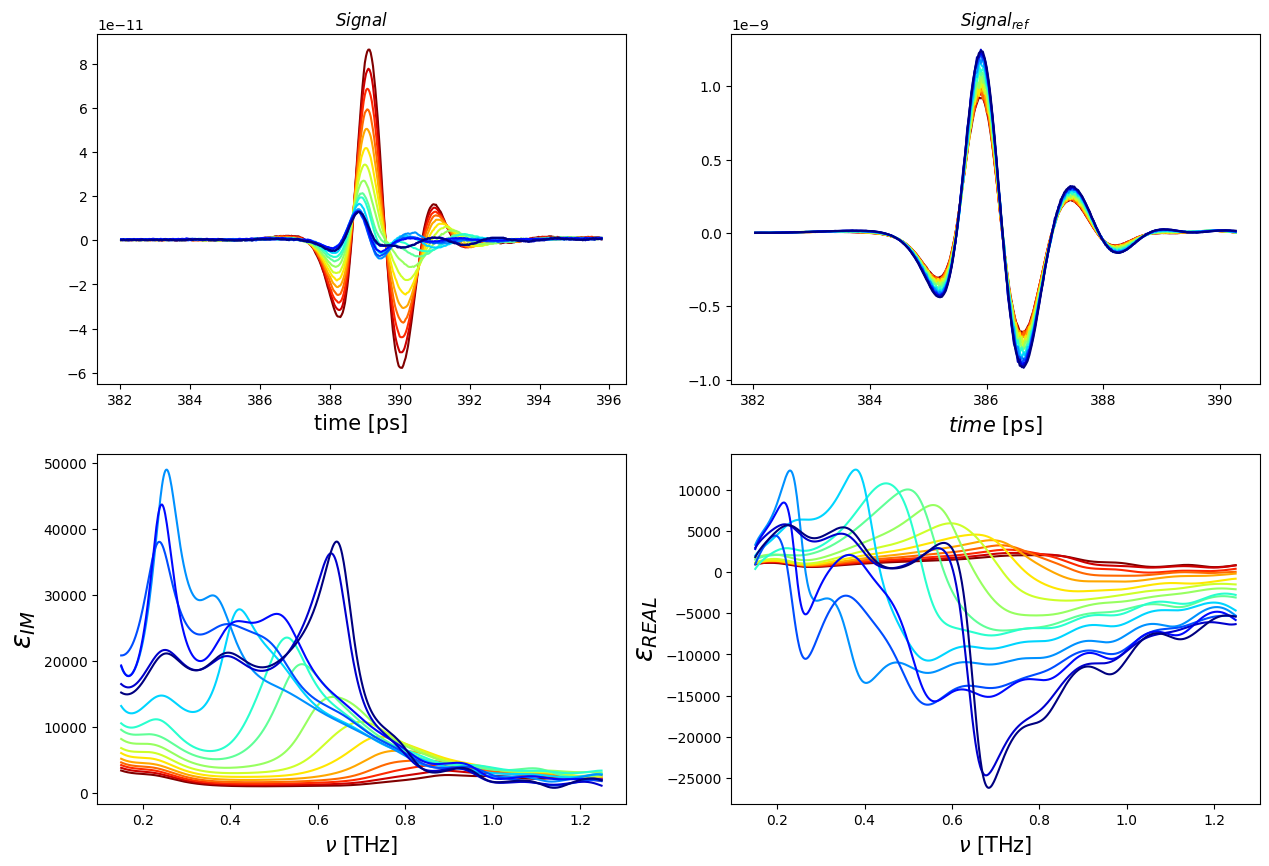

In [34]:
# Leer los archivos .dat
f = plt.figure(figsize=(15,10))
permitivadade = []
for i,j in enumerate(archivos_ordenados_s[::-1]):

    try:

        df1 = pd.read_csv(os.path.join(path_analisis,j), delim_whitespace=True)
        df1 = df1.loc[(df1.iloc[:, 0] >= 382) & (df1.iloc[:, 0] <=nk1)]
        df1_ref = pd.read_csv(os.path.join(path_analisis_ref,archivos_ordenados_ref[i]), delim_whitespace=True)
        df1_ref  = df1_ref .loc[(df1_ref .iloc[:, 0] >= 382) & (df1_ref .iloc[:, 0] <=nk2)]
        # plt.subplot(131)

        # plt.plot(df1['pos'],df1['X'],label=  extraer_temperatura2(j))
        # plt.plot(df1_ref['pos'],df1_ref['X'])
        # plt.legend()
        
        
        # ind = 150

        y = df1['X']
        y_ref = df1_ref['X']

        x = df1['pos']
        
        x_ref = df1_ref['pos']

        plt.subplot(221)

        plt.plot(x ,y,label= extraer_temperatura2(j),color = colors[i])
        plt.title('$Signal$')
        plt.xlabel('time [ps]',fontsize=15)
        #plt.legend()

        plt.subplot(222)

        plt.plot(x_ref ,y_ref,label= extraer_temperatura2(j),color = colors[i])
        plt.title('$Signal_{ref}$')
        plt.xlabel('$time$ [ps]',fontsize=15)
        #plt.legend()


        k = 15
        
        #nu = nu[1:len(nu)//k]
    
        plt.subplot(223)
        
        nu = sp.fft.fftfreq(2**14,1/30)
        y = FourierT(y)[1:len(nu)//k]
        y_ref = FourierT(y_ref)[1:len(nu)//k]
        nu = nu[1:len(nu)//k]
        xmin,xmax = 0.15, 1.25
        mask = (nu >= xmin) & (nu <= xmax)
        nu = nu[mask]
        y = y[mask]
        y_ref = y_ref[mask]

        T = (y/y_ref)*np.exp(2*np.pi*1j*nu/c*(1-2.6)*delta_ls[sample]) #delta_ls[sample])
        n = 2.6
        ep =1j*(1+n)*((1/T)-1)*c/(2*np.pi*nu*substrate[sub])-n
        permitivadade.append(ep)
        
        plt.plot(nu,np.imag(ep),label=extraer_temperatura2(j),color = colors[i])
        #plt.plot(nu,np.imag(ep_real(nu,*optimized_params)))
        plt.ylabel('$\epsilon_{IM}$',fontsize=20)
        plt.xlabel(r'$\nu$ [THz]',fontsize=15)
        # plt.xlim(0.15,1.25)
        # plt.ylim(-2000,35000)

        plt.subplot(224)
        #plt.plot(nu,abs(y),label=  extraer_temperatura(j))
        plt.plot(nu,np.real(ep),label=  extraer_temperatura2(j),color = colors[i])
        #plt.plot(nu,np.imag(ep_real(nu,*optimized_params)))
        # plt.xlim(0.15,1.25)
        plt.ylabel('$\epsilon_{REAL}$',fontsize=20)
        plt.xlabel(r'$\nu$ [THz]',fontsize=15)
        # plt.ylim(-15000,15000)
        #plt.yscale('log')<
        #plt.legend()
    except f as Exception:
        print(1)

# Fitting

In [199]:
# Create an independent variable with 100 measurements

def anim2(index):

    # xmin,xmax = 0.15, 1.25
    x = nu
    # mask = (x >= xmin) & (x <= xmax)
    # x = x[mask]
    yNoisy = permitivadade[int(index)]

    yReal = np.real(yNoisy)
    yImag = np.imag(yNoisy)

    params = fit_complex(x,yNoisy)
    # yBoth = np.hstack([yReal, yImag])

    # # Split the measurements into a  real and imaginary part
    # picos, _ = find_peaks(yImag)
    # # Encuentra los índices de los picos que están en el intervalo
    # indices_intervalo = [i for i in picos]
    # pico_maximo_idx = indices_intervalo[np.argmax(yImag[indices_intervalo])]
    # pico_maximo_x = x[pico_maximo_idx]
    # pico_maximo_y = yImag[pico_maximo_idx]
    # altura_media = pico_maximo_y / 2
    # indices_corte = np.where(np.abs(yImag - altura_media) < umbral)[0]
    # indices_corte_intervalo = [i for i in indices_corte]
    # x_cortes = x[indices_corte_intervalo]
    # ancho_media_altura = x_cortes[-1] - x_cortes[0]
    # #print(x_cortes)
    # print(f"El ancho a media altura es aproximadamente {ancho_media_altura:.2f}")



    # lim_inf = [0, 0, 0.6-0.05, 0.00000, 0.00000, 0.00000] # 0.77868 # 0.06% -> 0.54868[::-1] # 0.10% -> 0.28562
    # lim_sup = [np.inf, np.inf, 0.6+0.05, np.inf, np.inf, np.inf] # 1.29225
    # # ep_inf,ep_s,nu_to,Gamma,nu_p,gamma
    # p0 = [1e-3,1e-3,pico_maximo_x,ancho_media_altura,50,0.4]
    # # Find the best-fit solution
    # poptBoth, pcovBoth = curve_fit(epsilonboth, np.hstack([x, x]), yBoth, maxfev=5000)
    # print(poptBoth)
    # Compute the best-fit solution
    yFit = epsilon(x, *params)
    #print(poptBoth)

    # Plot the results
    plt.figure(figsize=(13, 4))

    plt.subplot(121)
    plt.plot(x, np.real(yNoisy), "k.",label= str(extraer_temperatura2(archivos_ordenados_s[::-1][int(index)]))+' K',color = colors[int(index)] )
    #plt.plot(x, np.real(y), "r--", label="True y")
    plt.plot(x, np.real(yFit),'--k', label="Best fit")
    
    #plt.xlim(0.15,1.25)
    plt.ylabel('$\epsilon_{REAL}$',fontsize=20)
    #plt.ylim(-15000,15000)
    #plt.ylabel("Real part of y")
    plt.xlabel(r"$\nu$ $[THz]$")
    plt.legend()

    plt.subplot(122)
    
    #print(pico_maximo_x)
    # pico_maximo_y = np.imag(yNoisy)[pico_maximo_idx]
    plt.plot(x, np.imag(yNoisy), "k.",label= str(extraer_temperatura2(archivos_ordenados_s[::-1][int(index)]))+' K',color = colors[int(index)] )
    plt.plot(x, np.imag(yFit),'--k',label="Best fit")
    # plt.plot(pico_maximo_x, pico_maximo_y , 'ro', label='Maximum')
    # #plt.plot(x, np.imag(y), "r--")
    
    # #print(np.imag(yFit))
    # plt.axhline(altura_media, color='gray', linestyle='--', label='Altura a media altura')
    plt.ylabel(r'$\epsilon_{IM}$',fontsize=20)
    plt.legend()
    #lt.xlim(0.15,1.25)f
    #plt.ylim(-2000,35000)

    plt.xlabel(r"$\nu$ $[THz]$")



opc=dict(continuous_update=False,readout_format=".3f")
interact(anim2,       
        index= widgets.FloatSlider(min=0,max=len(archivos_ordenados_s)-1,value=9,step=1,**opc)
        );



interactive(children=(FloatSlider(value=9.0, continuous_update=False, description='index', max=15.0, readout_f…

# Parameters vs temperature

In [200]:
x = nu
ep_inf,ep_s,nu_to,Gamma,nu_p,gamma = [],[],[],[],[],[]


for permit in permitivadade[::-1]:

    yNoisy = permit
    yReal = np.real(yNoisy)
    yImag = np.imag(yNoisy)
    params = fit_complex(x,yNoisy)
    ep_inf.append(params[0])
    ep_s.append(params[1])
    nu_to.append(params[2])
    Gamma.append(params[3])
    nu_p.append(params[4])
    gamma.append(params[5])

temp_parameters, pcovBoth = curve_fit(T_crit,Temp,nu_to, maxfev=5000)

C:\Users\usuario_trabajo\AppData\Local\Temp\ipykernel_39196\1843611139.py:43: OptimizeWarning: Covariance of the parameters could not be estimated
  poptBoth, pcovBoth = curve_fit(epsilonboth, np.hstack([x, x]), yBoth, maxfev=20000)


# Save data

Archivo guardado como PbTe


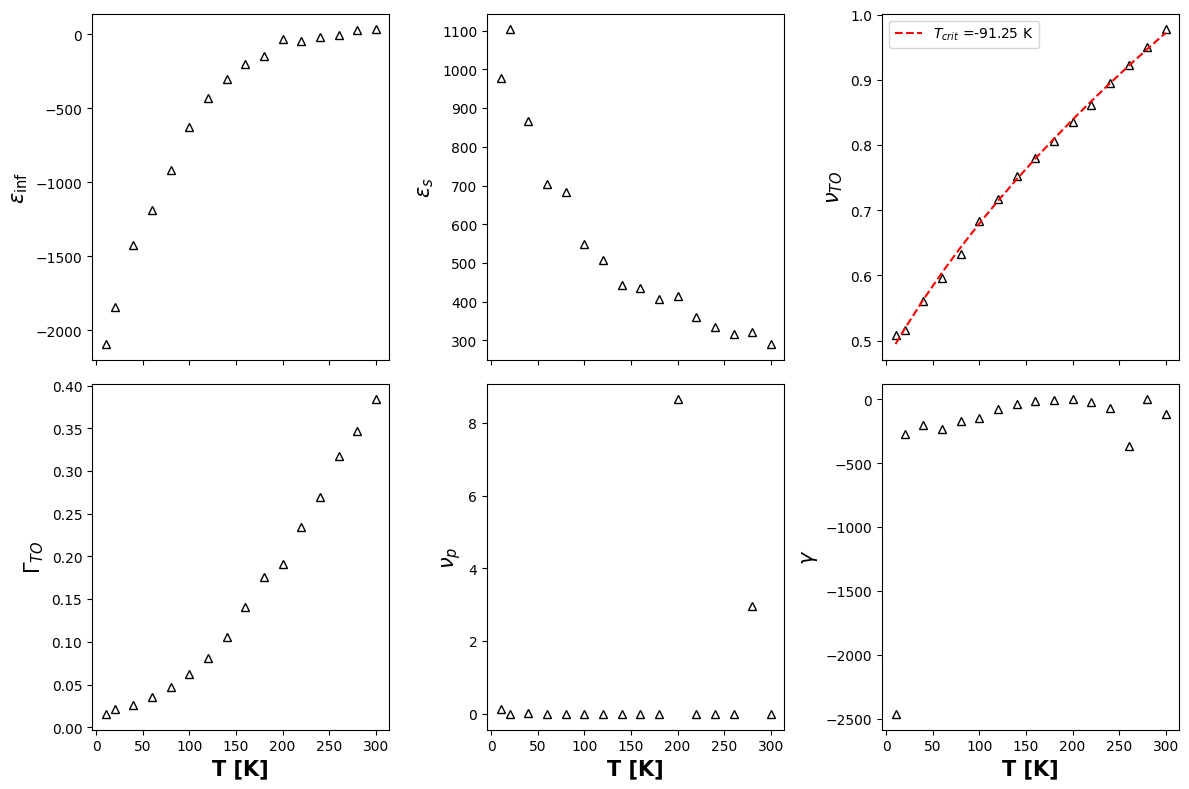

In [201]:
# Crear la figura y los ejes en una grilla 2x3
fig, axes = plt.subplots(2, 3, figsize=(12, 8))  # Tamaño ajustado

# Listas de los datos y títulos
y_data = [ep_inf, ep_s, nu_to, Gamma, nu_p, gamma]
titles = ['$\epsilon_{\inf}$', '$\epsilon_{s}$', r'$\nu_{TO}$', '$\Gamma_{TO}$', r'$\nu_p$', '$\gamma$']

# Iterar sobre los ejes y dibujar los gráficos
for i, ax in enumerate(axes.flat):
    #ax.plot(Temp[::-1], y_data[i], marker='^', color='black')
    ax.plot(Temp, y_data[i], marker='^', color='black', linestyle='none', markerfacecolor='none')
    #ax.set_title(titles[i])
    #ax.set_xlabel('x')
    ax.set_ylabel(titles[i], fontweight='bold',fontsize=15)

    if i==2:
        ax.plot(Temp,T_crit(Temp,*temp_parameters),'--r',label =r'$T_{crit}$ =' +str(round(temp_parameters[1],2))+' K' )
        ax.legend()
    if i <3:
        ax.set_xticklabels([])
    if i >= 3:  # Fila 2
        ax.set_xlabel('T [K]', fontweight='bold',fontsize=15)
    #ax.set_ylabel(titles[i])
    #ax.grid(True)  # Agregar grillas para mejor visualización

# Ajustar el espaciado entre los subgráficos
plt.tight_layout()

# Mostrar la figura
plt.show()


In [ ]:
# Crear un diccionario con los datos
data = {
    'Temp': Temp,
    'ep_inf': ep_inf,
    'ep_s': ep_s,
    'nu_to': nu_to,
    'Gamma': Gamma,
    'nu_p': nu_p,
    'gamma': gamma
}

# Crear un DataFrame
df = pd.DataFrame(data)

# Guardar en un archivo CSV con un nombre específico
nombre_archivo = sample
df.to_csv(nombre_archivo, index=False)

print(f"Archivo guardado como {nombre_archivo}")

# Plot 